In [2]:
import numpy as np
import pandas as pd
import os
import re
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches # légende
import csv
from scipy.stats import linregress

# Paramétrage de l'affichage des dataframes
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', None)

In [3]:
# Détermination du temps de vieillissement à partir du nom de fichier
def age(parameters):
    compound_mapping = {
        'T0': 0,
        'T1': 14,
        'T2': 33,
        'T3': 42,
        'T4': 61,
        'T5': 80,
        '15122023': 294,
        '19012024': 329,
        '08022024': 349,
        '23022024': 364,
        '08032024': 378,
        '22032024': 392,
        '05042024': 406,
        '19042024': 420,
        '03052024': 434,
        '17052024': 448,
        '07062024': 462
    }
    
    for key, value in compound_mapping.items():
        if key in parameters:
            return value
    return 0

In [4]:
# Détermination du type de matériau à partir du nom de fichier
# Tient compte de toutes les nomenclatures utilisées pendant 
# les stages SPECTRAA et DEGRAA-D
def compound(filename):
    parameters = re.split(r'[-_. ]', filename)
    #print(parameters)
    compound_mapping = {
        ('12', 'a'): 'Caoutchouc',
        ('12', 'su'): 'PVC',
        ('13', 'a'): 'Acrylique',
        ('13', 'su'): 'AC',
        ('14', 'a'): 'Caoutchouc',
        ('14', 'su'): 'PP',
        ('15', 'a'): 'Acrylique',
        ('15', 'su'): 'PET',
        ('16', 'a'): 'Acrylique',
        ('16', 'su'): 'PP',
        ('12', 'fa'): 'Caoutchouc',
        ('12', 'su'): 'PVC',
        ('13', 'fa'): 'Acrylique',
        ('13', 'su'): 'AC',
        ('14', 'fa'): 'Caoutchouc',
        ('14', 'su'): 'PP',
        ('15', 'fa'): 'Acrylique',
        ('15', 'su'): 'PET',
        ('16', 'fa'): 'Acrylique',
        ('16', 'su'): 'PP',
        ('RAA12', 'MAPrelevement'): 'Caoutchouc',
        ('RAA12', 'FilmsPrelevement'): 'PVC',
        ('RAA13', 'MAPrelevement'): 'Acrylique',
        ('RAA13', 'FilmsPrelevement'): 'AC',
        ('RAA14', 'MAPrelevement'): 'Caoutchouc',
        ('RAA14', 'FilmsPrelevement'): 'PP',
        ('RAA15', 'MAPrelevement'): 'Acrylique',
        ('RAA15', 'FilmsPrelevement'): 'PET',
        ('RAA16', 'MAPrelevement'): 'Acrylique',
        ('RAA16', 'FilmsPrelevement'): 'PP',
        ('RAA12', 'fa'): 'Caoutchouc',
        ('RAA12', 'fna'): 'PVC',
        ('RAA13', 'fa'): 'Acrylique',
        ('RAA13', 'fna'): 'AC',
        ('RAA14', 'fa'): 'Caoutchouc',
        ('RAA14', 'fna'): 'PP',
        ('RAA15', 'fa'): 'Acrylique',
        ('RAA15', 'fna'): 'PET',
        ('RAA16', 'fa'): 'Acrylique',
        ('RAA16', 'fna'): 'PP',
        ('RAA12', 'fa'): 'Caoutchouc',
        ('RAA12', 'fna'): 'PVC',
        ('RAA13', 'fa'): 'Acrylique',
        ('RAA13', 'fna'): 'AC',
        ('RAA14', 'fa'): 'Caoutchouc',
        ('RAA14', 'fna'): 'PP',
        ('RAA15', 'fa'): 'Acrylique',
        ('RAA15', 'fna'): 'PET',
        ('RAA16', 'fa'): 'Acrylique',
        ('RAA16', 'fna'): 'PP',
        ('RAA12', 'MA'): 'Caoutchouc',
        ('RAA12', 'FILM'): 'PVC',
        ('RAA12', 'Film'): 'PVC',
        ('RAA13', 'MA'): 'Acrylique',
        ('RAA13', 'FILM'): 'AC',
        ('RAA13', 'Film'): 'AC',
        ('RAA14', 'MA'): 'Caoutchouc',
        ('RAA14', 'FILM'): 'PP',
        ('RAA14', 'Film'): 'PP',
        ('RAA15', 'MA'): 'Acrylique',
        ('RAA15', 'FILM'): 'PET',
        ('RAA15', 'Film'): 'PET',
        ('RAA16', 'MA'): 'Acrylique',
        ('RAA16', 'FILM'): 'PP',
        ('RAA16', 'Film'): 'PP'
    }
    
    for key, value in compound_mapping.items():
        if key[0] in parameters and key[1] in parameters:
            return value
    return filename

In [5]:
# Indiquer emplacement des données
#directory = r'/Users/prénomnom/Desktop/Fichier' (exemple)
directory = r'/Users/nicolasgros/Desktop/Études/Stages/INP - CRCC/PCA SPECTRAA'

# Les fichiers sont nommés :
# RAAXX.(frais).jjmmaaaa.fa/fna.(numéro de triplicat).csv

dataframes = []
tapes = []
ages = []
filenames = []
compounds = []
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=2, delimiter=';', names=['Wavelength', 'Absorbance'], dtype={'Wavelength': int, 'Absorbance': float}, index_col='Wavelength', decimal=',')
        parameters = re.split(r'[-._ ]', filename)
        with open(file_path, 'r') as file:
            csv_reader = csv.reader(file, delimiter=';')
            next(csv_reader)  # Skip the first row
            row = next(csv_reader)  # Read the second row
            value = row[1]  # Extract the value from the second column
        if value == '%T' : # Conversion des données de transmitance en absorbance
            df['Absorbance'] = - 2 * np.log(df['Absorbance'] / 100)
        tapes.append(parameters[0]) # Extrait le numéro de RAA du nom de fichier
        ages.append(age(parameters)) # Extrait le temps de vieillissement du nom de fichier
        filenames.append(filename) # Extrait le nom de fichier
        compounds.append(compound(filename)) # Extrait le type de matériau du nom de fichier
        dataframes.append(df)

# Concatenate all DataFrames and metadata
data = pd.concat(dataframes, axis=1)

# Create the final DataFrame
data = data.T.reset_index(drop=True).rename_axis('Index')

data['tape'] = tapes
data['compound'] = compounds
data['age'] = ages
data['file name'] = filenames

cols = list(data.columns)
cols = ['tape'] + [col for col in cols if col != 'tape']
data = data[cols]

data.sort_values(by=['tape', 'compound', 'age'], inplace=True)
data.reset_index(drop=True, inplace=True)

data

Wavelength,tape,4000,3999,3998,3997,3996,...,402,401,400,compound,age,file name
0,RAA12,0.0011,0.0011,0.0011,0.0010,0.0010,...,0.0292,0.0288,0.0295,Caoutchouc,0,RAA12.frais.03502024.fa.2.csv
1,RAA12,0.0005,0.0006,0.0007,0.0007,0.0006,...,0.0288,0.0280,0.0270,Caoutchouc,0,RAA12.frais.03502024.fa.3.csv
2,RAA12,0.0010,0.0009,0.0009,0.0009,0.0010,...,0.0347,0.0348,0.0342,Caoutchouc,0,RAA12.frais.03502024.fa.1.csv
3,RAA12,0.0009,0.0009,0.0010,0.0010,0.0010,...,0.0542,0.0557,0.0563,Caoutchouc,294,RAA12.15122023.fa.csv
4,RAA12,0.0011,0.0011,0.0011,0.0011,0.0011,...,0.0405,0.0419,0.0432,Caoutchouc,329,RAA12.19012024.fa.csv
5,RAA12,0.0006,0.0007,0.0007,0.0008,0.0008,...,0.0504,0.0513,0.0535,Caoutchouc,349,RAA12.08022024.fa.csv
6,RAA12,0.0009,0.0009,0.0009,0.0009,0.0009,...,0.0542,0.0541,0.0540,Caoutchouc,364,RAA12.23022024.fa.csv
7,RAA12,0.0010,0.0006,0.0001,0.0000,0.0003,...,0.0514,0.0537,0.0553,Caoutchouc,378,RAA12.08032024.fa.csv
8,RAA12,0.0005,0.0004,0.0004,0.0004,0.0004,...,0.0482,0.0476,0.0472,Caoutchouc,392,RAA12.22032024.fa.csv
9,RAA12,0.0006,0.0005,0.0004,0.0004,0.0003,...,0.0475,0.0520,0.0523,Caoutchouc,406,RAA12.05042024.fa.csv


In [6]:
# Calcul de l'indice de dégradation à partir des intensités
def indice_int(df, row, target, ref):
    
    peaks, _ = find_peaks(df.iloc[row, 1:-40], height=0.005) #-5 car peak_area ajouté
    peaks = 4000 - peaks
    I_peak = peaks[np.argmin(np.abs(peaks - target))]
    ref_peak = peaks[np.argmin(np.abs(peaks - ref))]
    
    I = df.iloc[row, df.columns.get_loc(I_peak)] / df.iloc[row, df.columns.get_loc(ref_peak)]

    return I

In [7]:
# Calcul de l'aire d'une bande d'absorption par la méthode des trapèzes
def peak_area(df, row, start, end):
    # Extract retention times and intensities
    Tr = df.columns[1:-3].astype(int)
    intensity_values_a = df.iloc[row, 1:-3].values
    
    # Ensure Tr is sorted in ascending order for np.searchsorted to work correctly
    sorted_indices = np.argsort(Tr)
    Tr = Tr[sorted_indices]
    intensity_values_a = intensity_values_a[sorted_indices]
    
    # Filter the retention times and intensities based on start and end
    start_idx = np.searchsorted(Tr, start, side='left')
    end_idx = np.searchsorted(Tr, end, side='right')
    Tr_filtered_a = Tr[end_idx:start_idx]
    intensity_filtered_a = intensity_values_a[end_idx:start_idx]
    
    # Calculate the area using the trapezoidal rule
    area = np.trapz(intensity_filtered_a, Tr_filtered_a)
            
    return area

In [8]:
# Calcul de l'indice de dégradation à partir des aires
def indice_area(df, row, target_min, target_max, ref_min, ref_max):
    
    target_area = peak_area(df, row, target_min, target_max)
    ref_area = peak_area(df, row, ref_min, ref_max)
    
    I = target_area / ref_area
    
    return I

In [9]:
# Représentation de l'évolution de l'indice de dégradation 
# en fonction du temps de vieillissement ()
def plot_figure(data_plot, y_label='Indice Carbonyle') :
    # Indiquer manuellement l'écart type mesuré sur le triplicat
    #std_value = 0.008531

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

    x_values = data_plot['age']
    y_values = data_plot['I']

    groups = data_plot.groupby('age')

    for age_value, group_data in groups:
        mean_value = np.mean(group_data['I'])

        # Plot the data points and error bars
        # Left plot (before the gap)
        ax1.scatter(x_values, y_values, color='black', alpha=0.5, s=10)
        #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
        ax1.set_xlim(-10, 10)

        # Right plot (after the gap)
        ax2.scatter(x_values, y_values, color='black', alpha=0.5, s=10)
        #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
        ax2.set_xlim(290, 470)

    # Hide the spines and ticks between the plots
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax1.tick_params(labelright=False)
    ax2.yaxis.tick_right()

    # Add diagonal lines to indicate the break
    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
    ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the right axes
    ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
    ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

    # Set labels and title for the subplot
    fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
    fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

    #plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

In [10]:
# Réprésentayion des spectres à tous les temps de vieillissement en taille réduite
# Utilisé pour les extraits de spectres sur des bandes spécifiques
def plot_spectrum_small(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(6, 3))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    for row in range(len(data_plot_spectra.values[:, 1:-4])):
        A = data_plot_spectra.values[:, 1:-4][row][(4000-w_start):(400-w_end)]
        #color = 'red'
        color = cmap[row]

        if data_plot_spectra.values[row, data_plot_spectra.columns.get_loc('age')] == 0:
            color = 'black'
        plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)

    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()

In [11]:
# Réprésentayion des spectres à tous les temps de vieillissement en taille normale
# Utilisé pour les spectres entiers
def plot_spectrum_test(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(12, 6))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    for row in range(len(data_plot_spectra.values[:, 1:-4])):
        A = data_plot_spectra.values[:, 1:-4][row][(4000-w_start):(400-w_end)]
        #color = 'red'
        color = cmap[row]

        if data_plot_spectra.values[row, data_plot_spectra.columns.get_loc('age')] == 0:
            color = 'black'
        plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)

    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()

## Plots Annexes

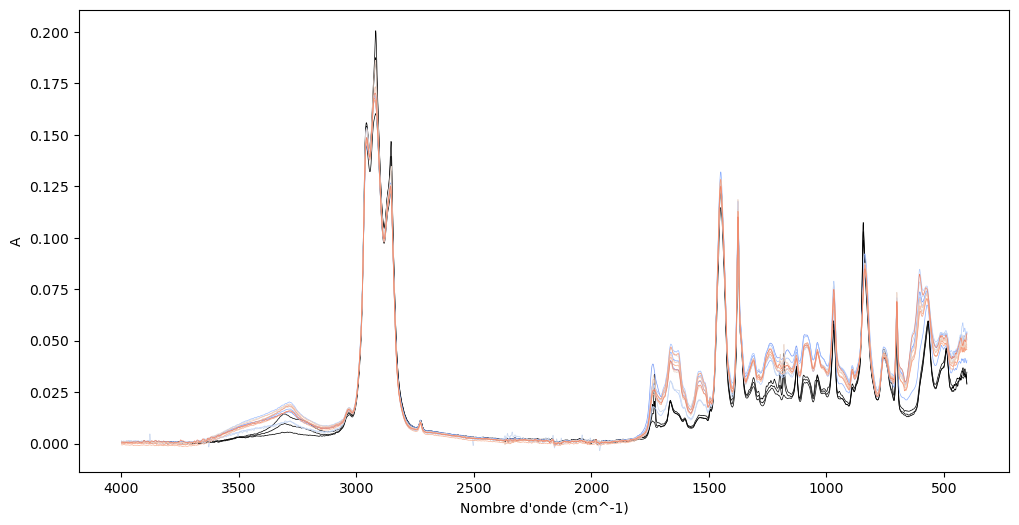

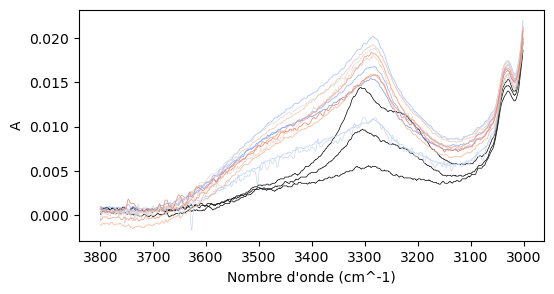

area


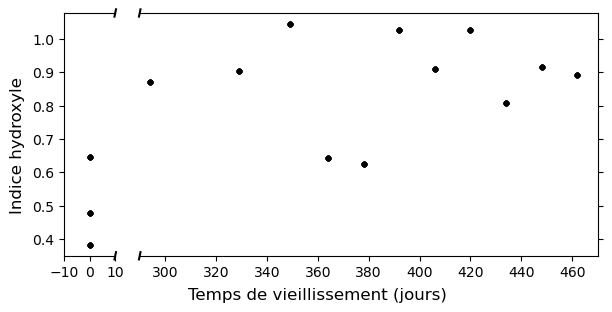

intensity


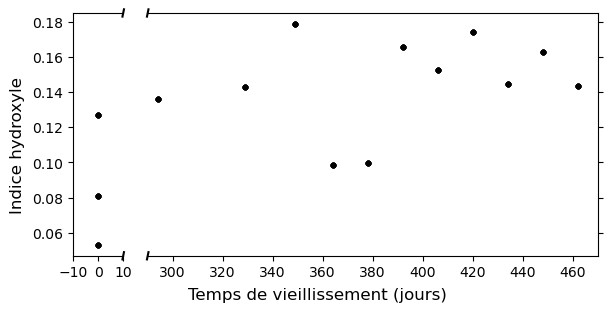

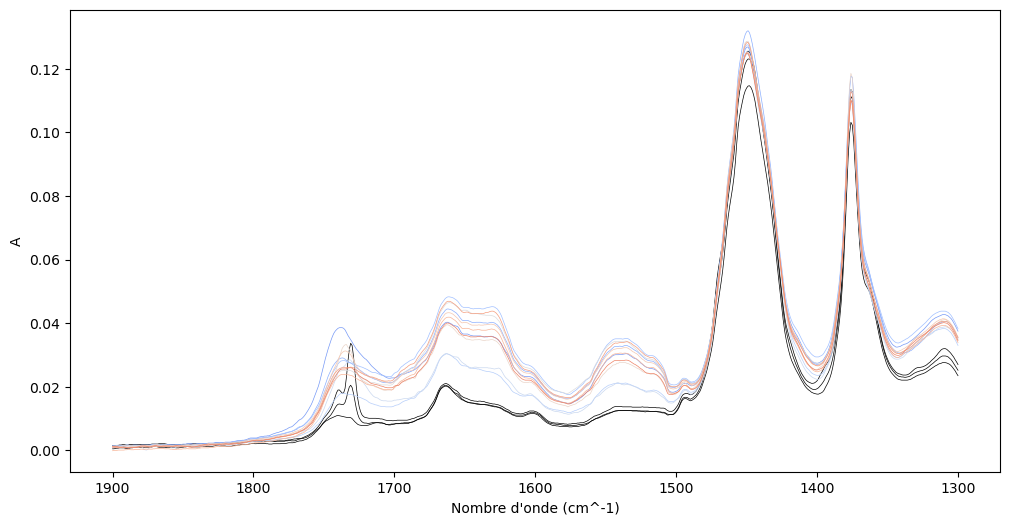

area


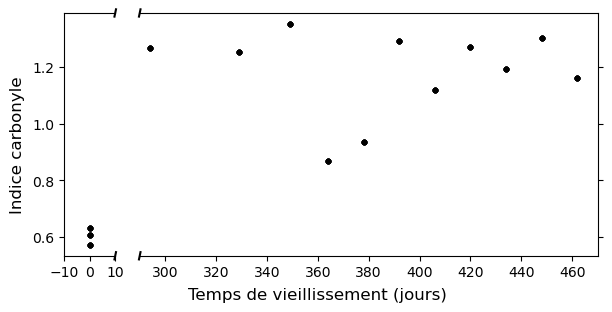

intensity


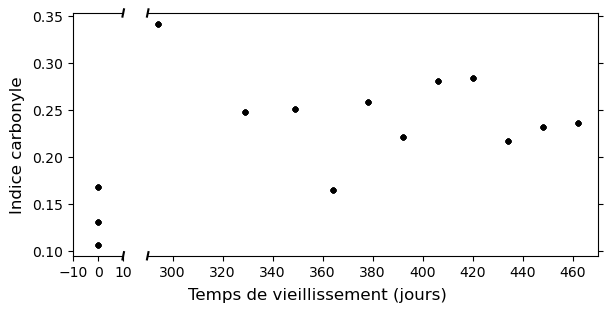

In [13]:
# Annexe 3
tape = 'RAA12'
compound = 'Caoutchouc'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 3800, 3000)

print('area')
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 3700, 3100, 1490, 1400), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice hydroxyle')

print('intensity')
data_working['I'] = data_working.apply(lambda row: indice_int(data, row.name, 3280, 1370), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice hydroxyle')

plot_spectrum_test(data_working, 1900, 1300)

print('area')
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1504, 1490, 1400), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')

print('intensity')
data_working['I'] = data_working.apply(lambda row: indice_int(data, row.name, 1740, 1370), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')

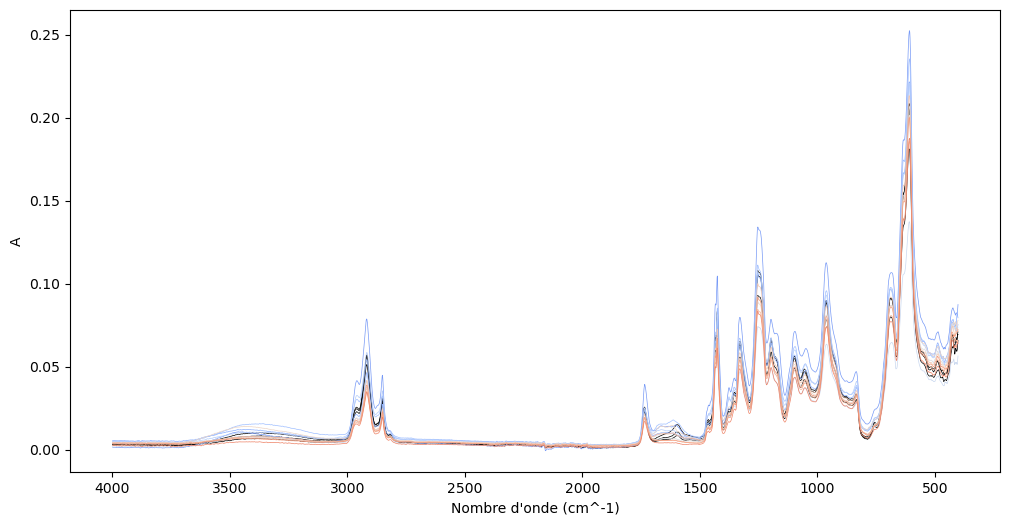

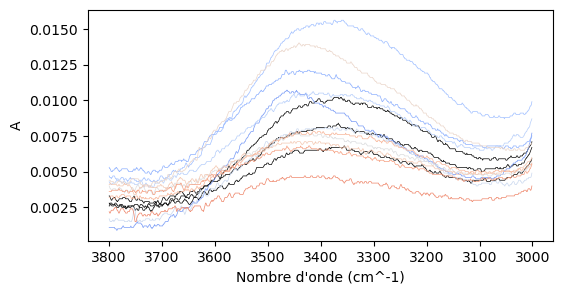

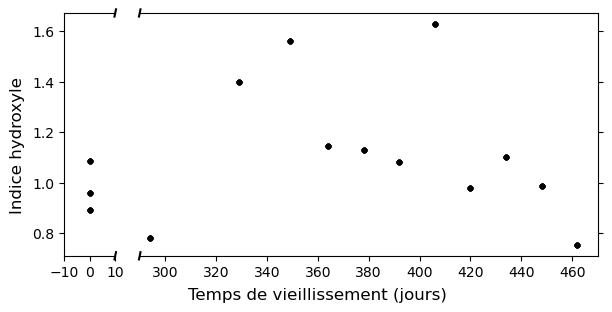

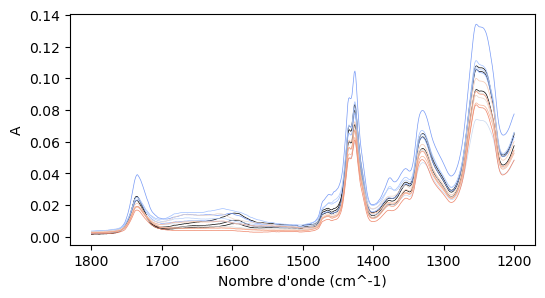

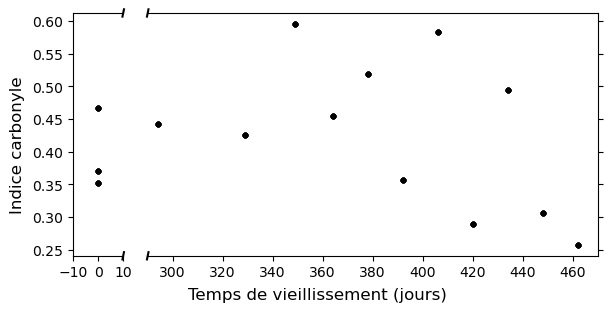

In [14]:
# Annexe 4
tape = 'RAA12'
compound = 'PVC'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 3800, 3000)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 3700, 3100, 1400, 1288), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice hydroxyle')


plot_spectrum_small(data_working, 1800, 1200)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1710, 1510, 1400, 1288), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')


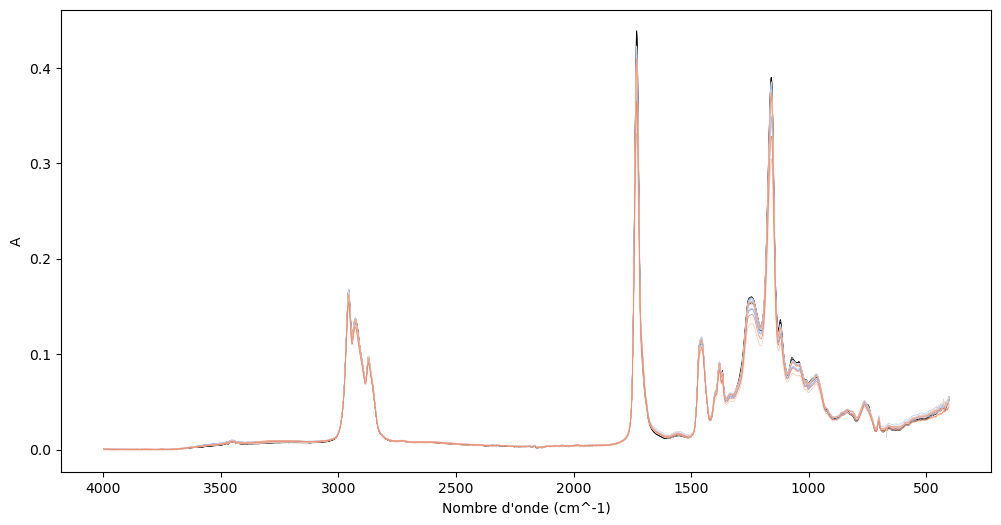

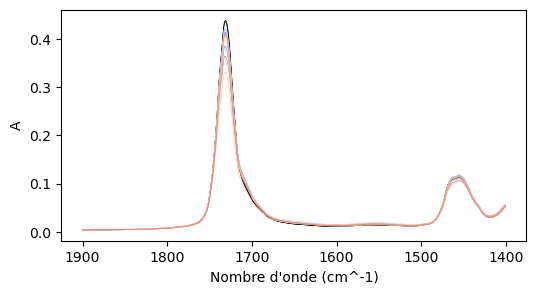

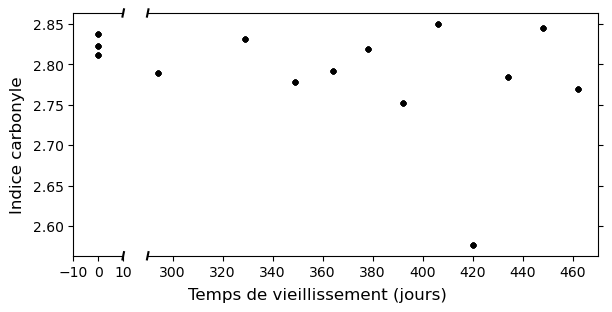

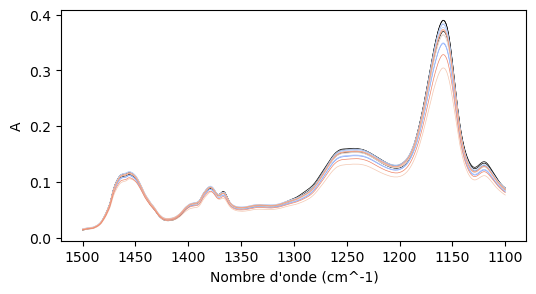

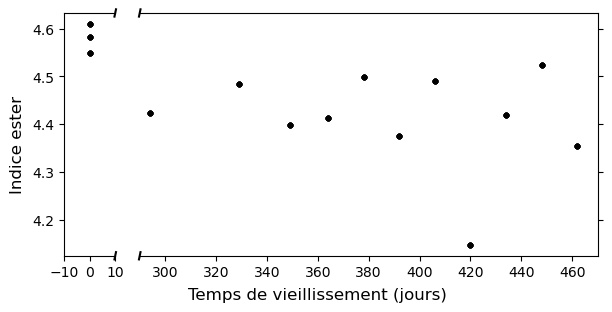

In [15]:
# Annexe 5
tape = 'RAA13'
compound = 'Acrylique'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 1900, 1400)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1620, 1500, 1420), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')


plot_spectrum_small(data_working, 1500, 1100)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1320, 1160, 1500, 1420), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice ester')


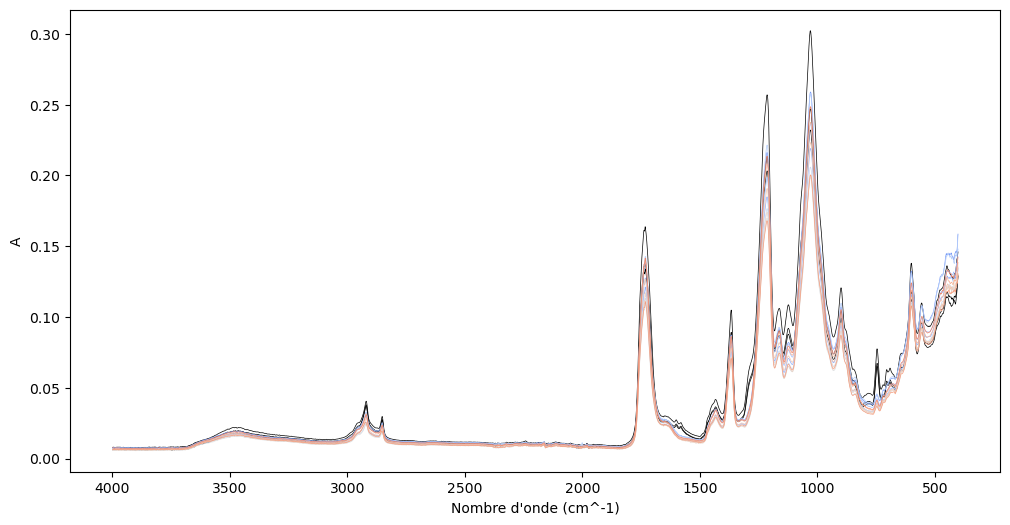

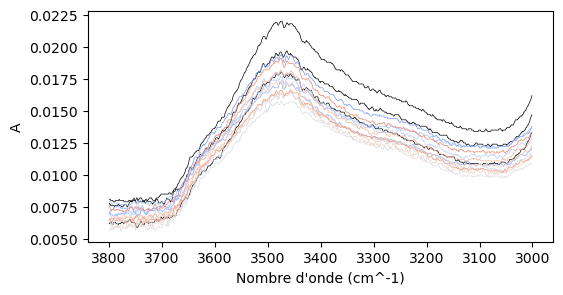

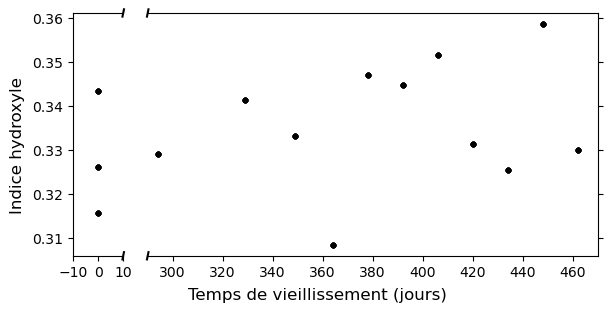

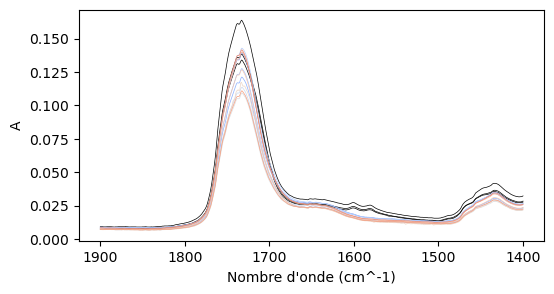

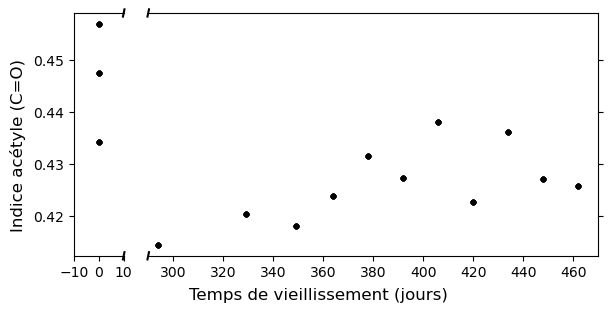

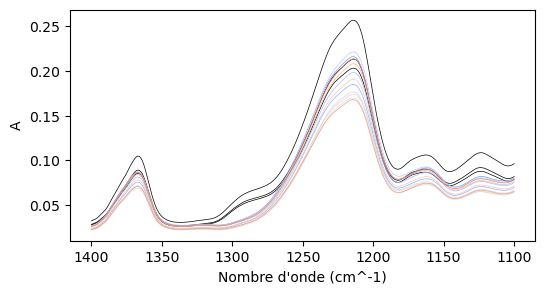

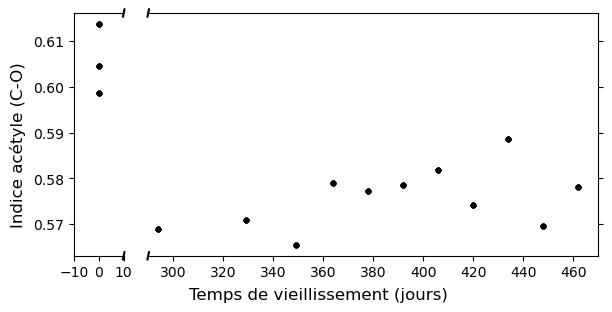

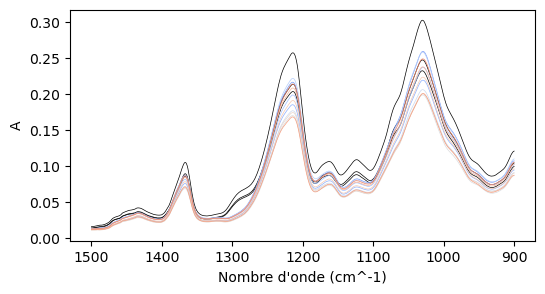

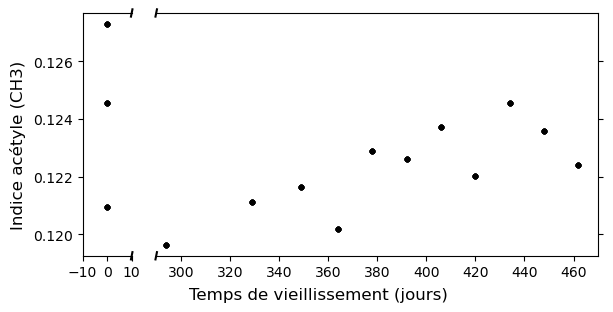

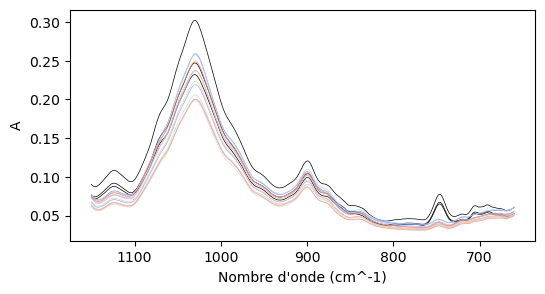

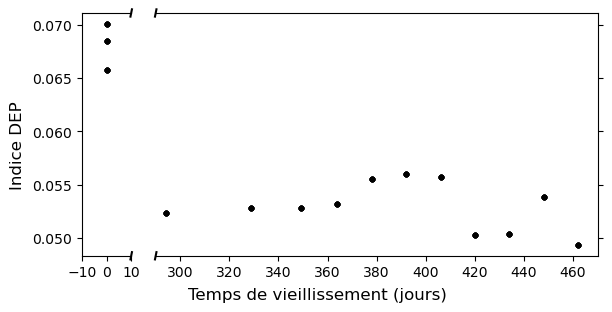

In [16]:
# Annexe 6
tape = 'RAA13'
compound = 'AC'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 3800, 3000)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 3700, 3100, 1100, 925), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice hydroxyle')


plot_spectrum_small(data_working, 1900, 1400)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1800, 1550, 1100, 925), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice acétyle (C=O)')

plot_spectrum_small(data_working, 1400, 1100)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1340, 1182, 1100, 925), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice acétyle (C-O)')

plot_spectrum_small(data_working, 1500, 900)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1403, 1340, 1100, 925), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice acétyle (CH3)')


plot_spectrum_small(data_working, 1150, 660)
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 765, 730, 1100, 925), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice DEP')


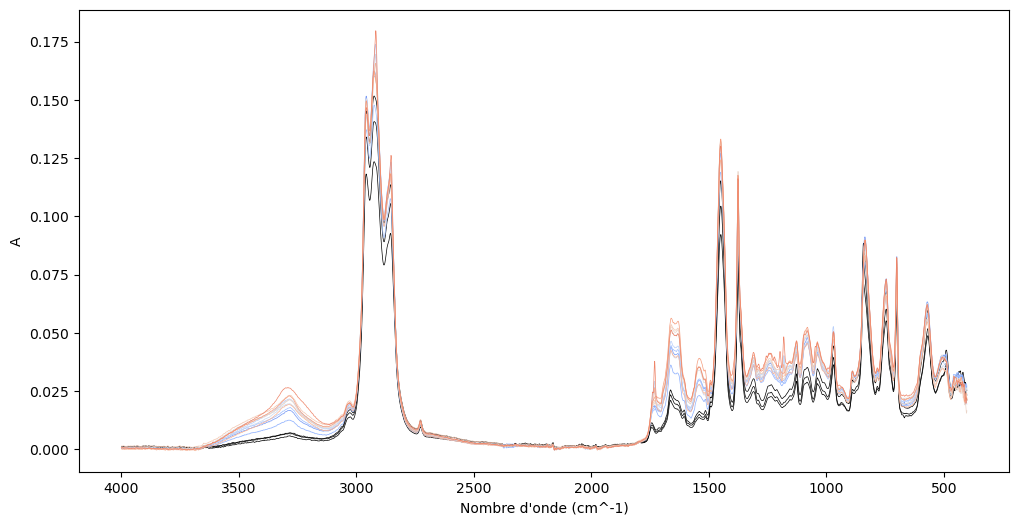

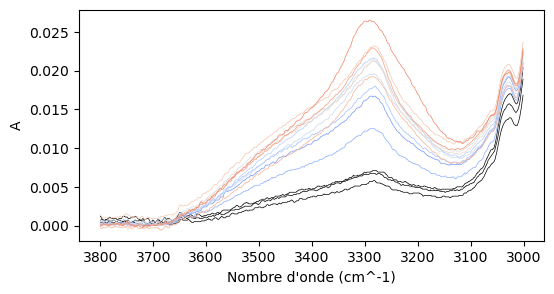

area


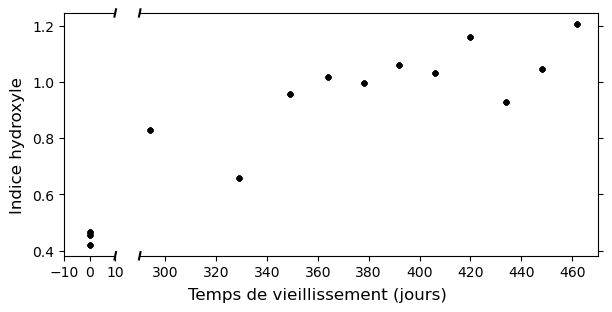

intensity


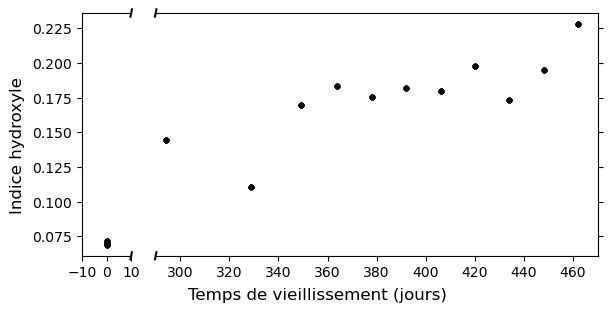

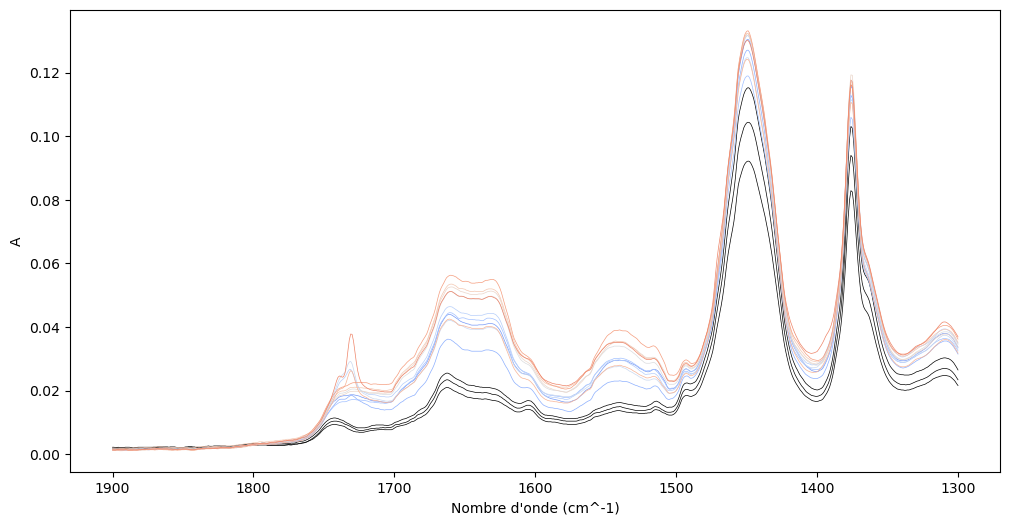

area


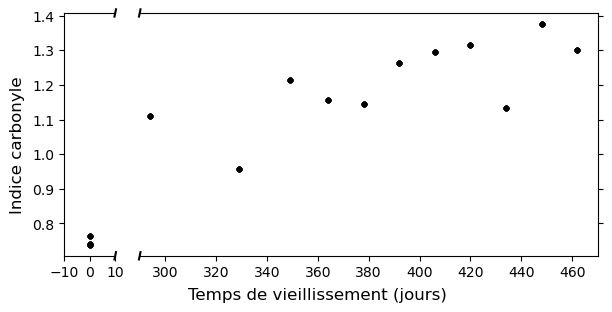

intensity


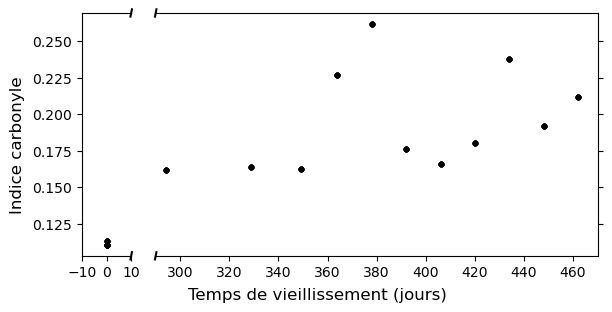

In [17]:
# Figure 10 et Annexe 7
tape = 'RAA14'
compound = 'Caoutchouc'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 3800, 3000)

print('area')
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 3700, 3100, 1490, 1400), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice hydroxyle')

print('intensity')
data_working['I'] = data_working.apply(lambda row: indice_int(data, row.name, 3280, 1370), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice hydroxyle')

plot_spectrum_test(data_working, 1900, 1300)

print('area')
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1504, 1490, 1400), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')

print('intensity')
data_working['I'] = data_working.apply(lambda row: indice_int(data, row.name, 1740, 1370), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')

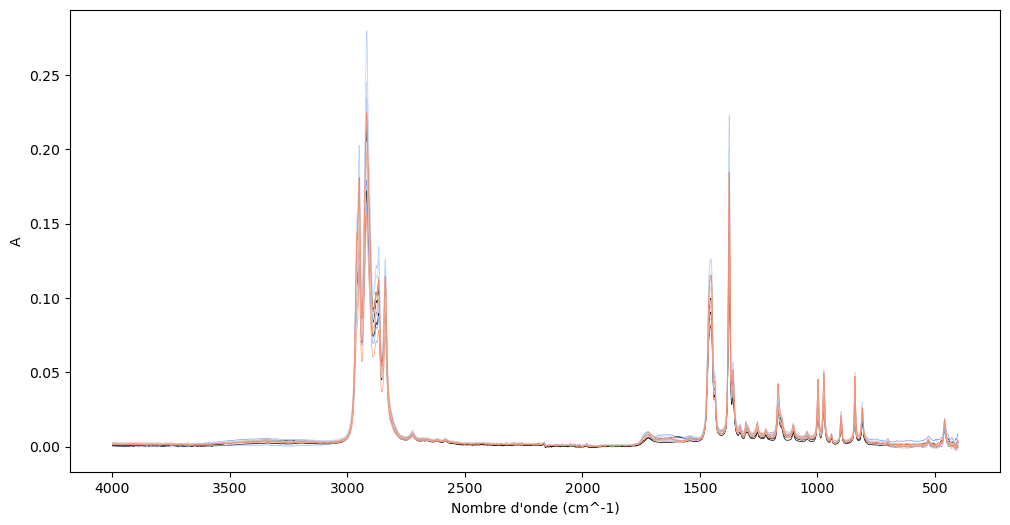

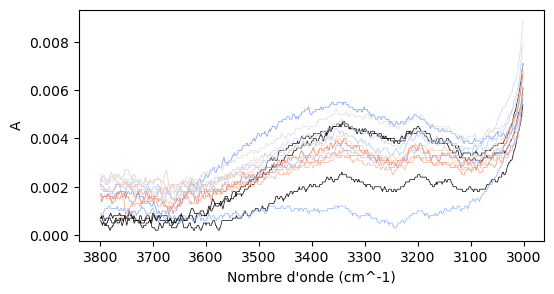

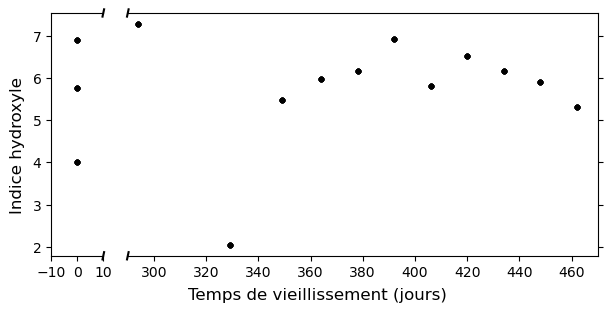

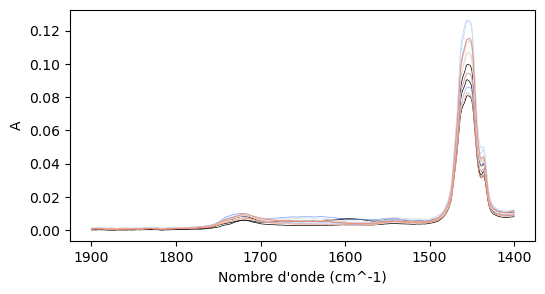

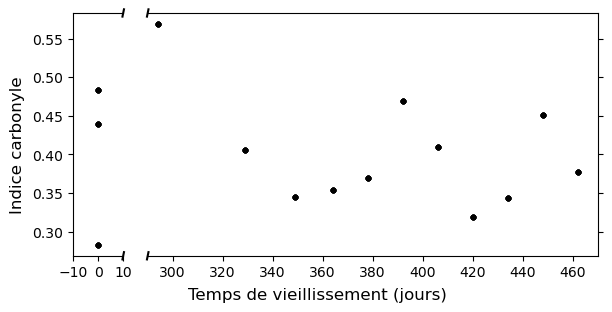

In [18]:
# Annexe 8
tape = 'RAA14'
compound = 'PP'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 3800, 3000)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 3700, 3100, 1425, 1395), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice hydroxyle')


plot_spectrum_small(data_working, 1900, 1400)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1520, 1500, 1410), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')

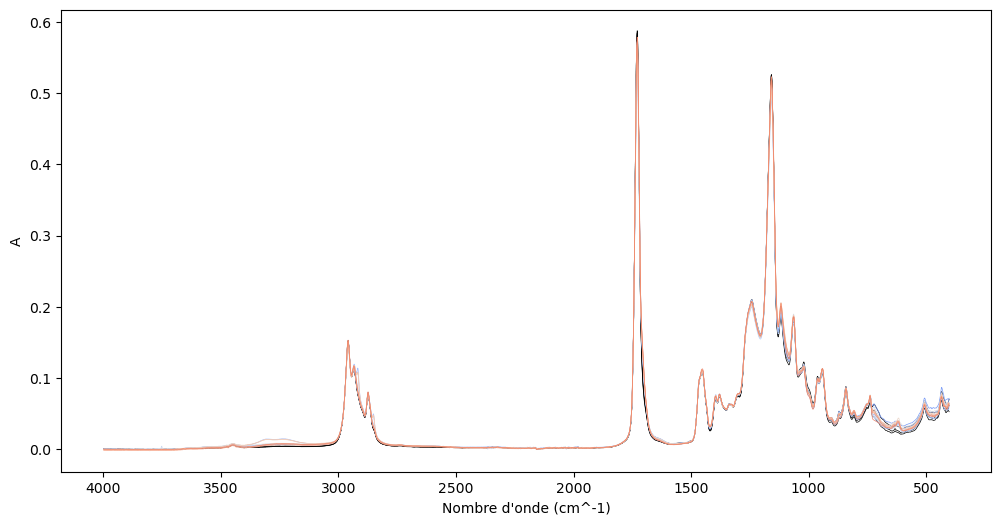

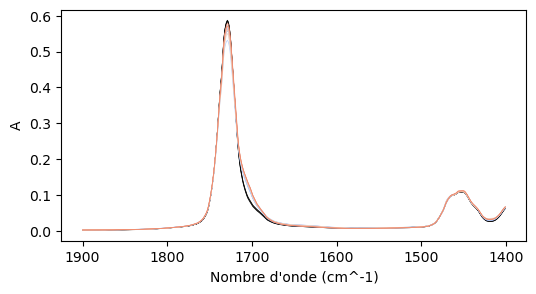

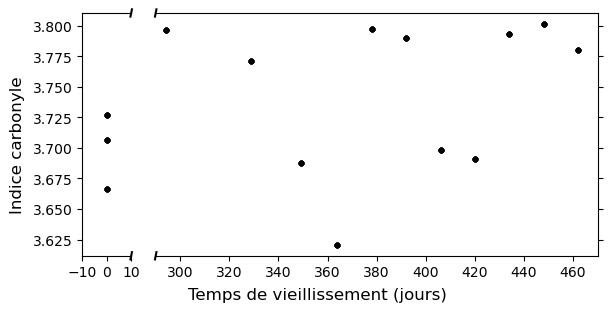

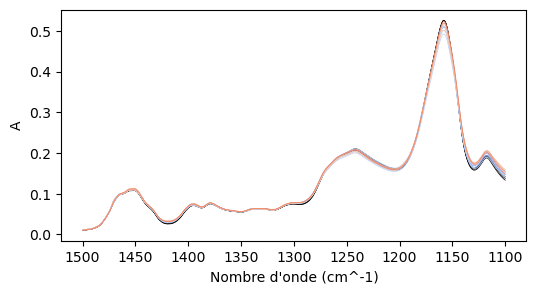

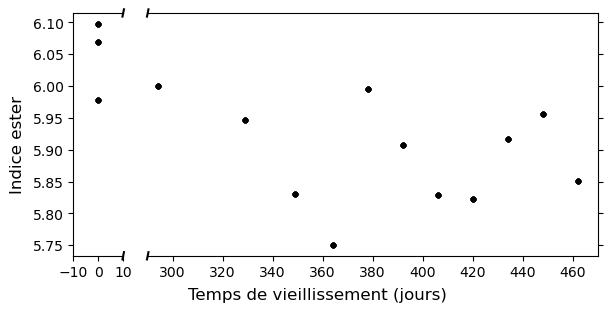

In [19]:
# Annexe 9
tape = 'RAA15'
compound = 'Acrylique'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 1900, 1400)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1620, 1500, 1420), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')


plot_spectrum_small(data_working, 1500, 1100)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1320, 1160, 1500, 1420), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice ester')


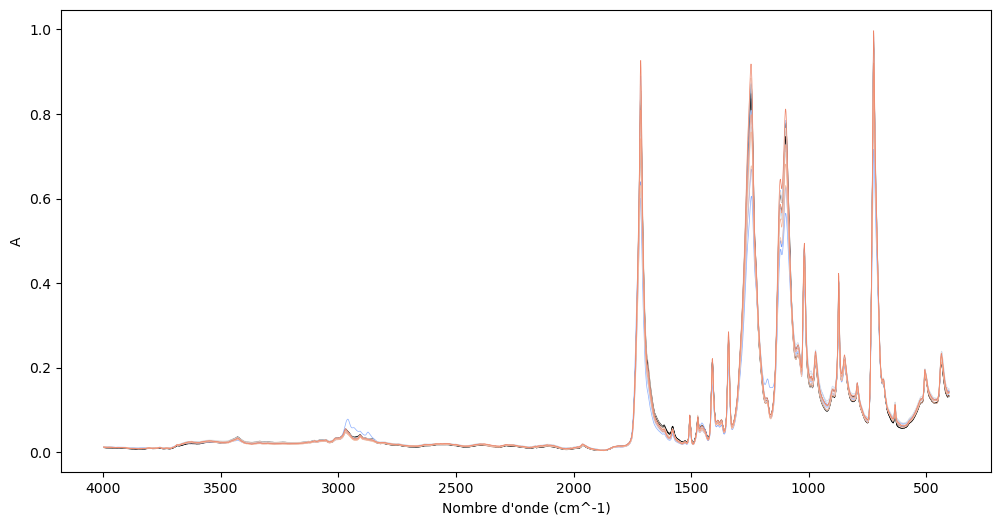

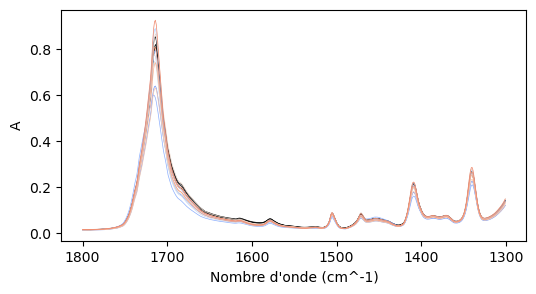

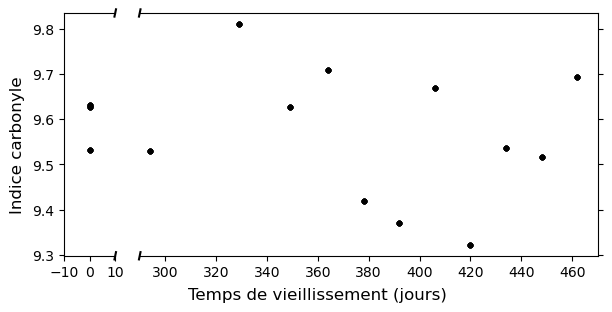

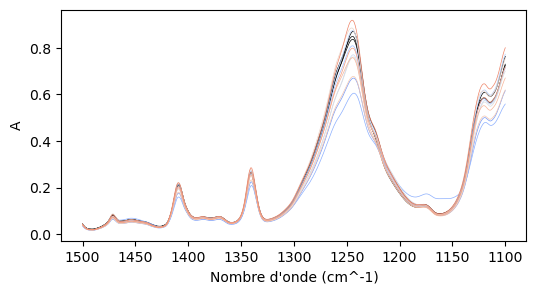

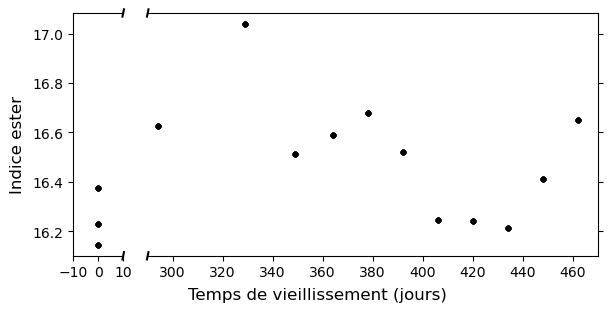

In [20]:
# Annexe 10
tape = 'RAA15'
compound = 'PET'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 1800, 1300)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1780, 1620, 1425, 1395), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')


plot_spectrum_small(data_working, 1500, 1100)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1327, 1160, 1425, 1395), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice ester')

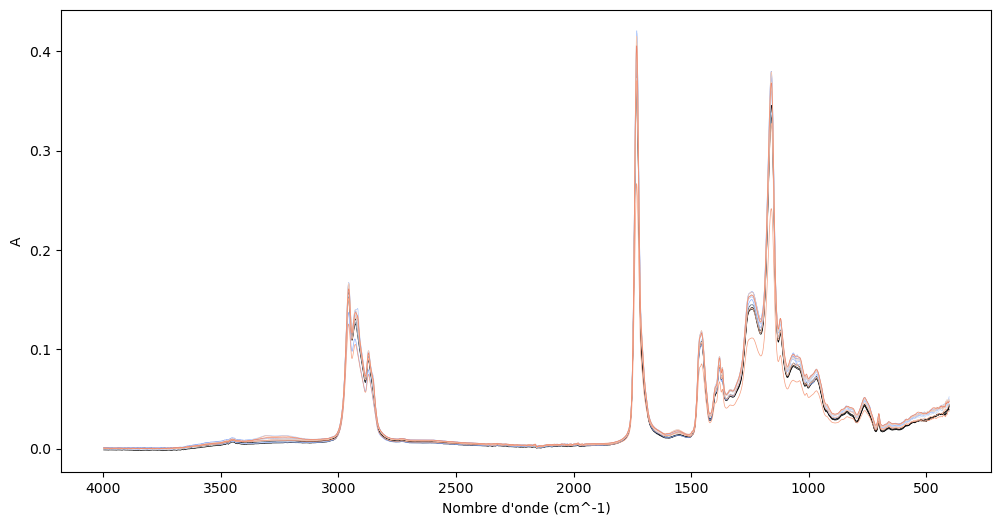

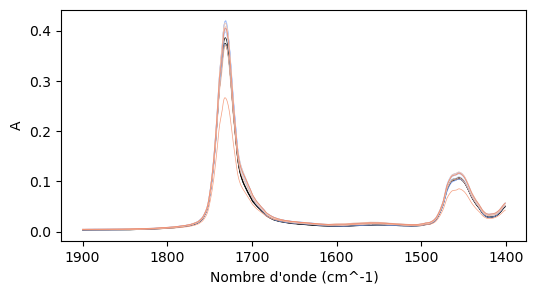

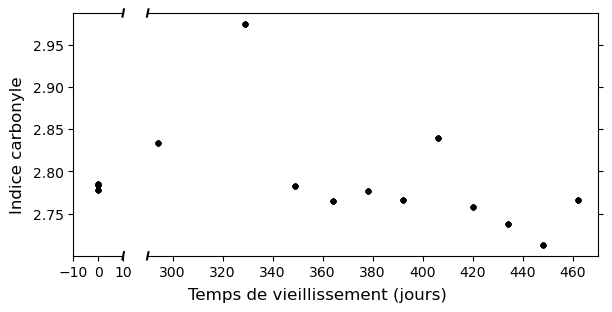

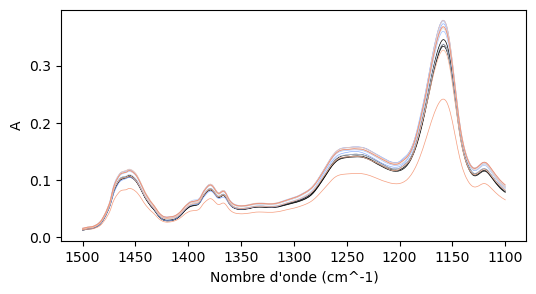

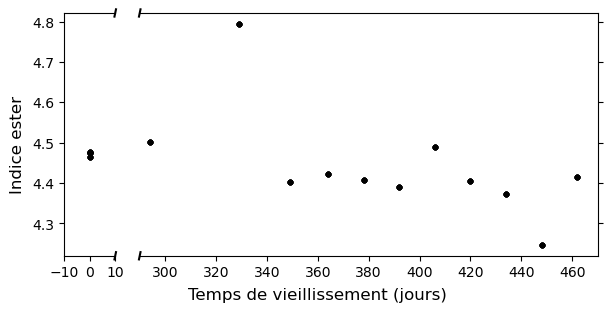

In [21]:
# Annexe 11
tape = 'RAA16'
compound = 'Acrylique'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 1900, 1400)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1620, 1500, 1420), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')


plot_spectrum_small(data_working, 1500, 1100)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1320, 1160, 1500, 1420), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice ester')


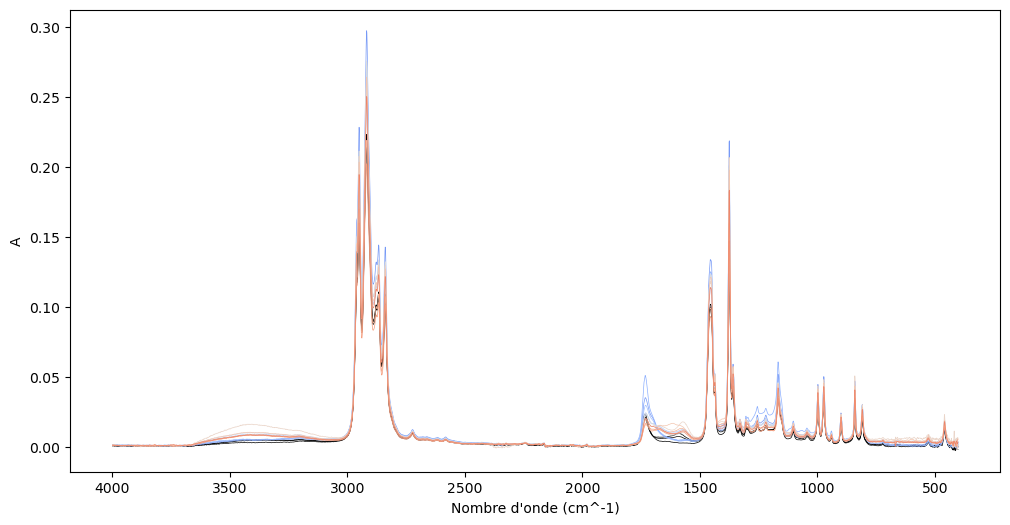

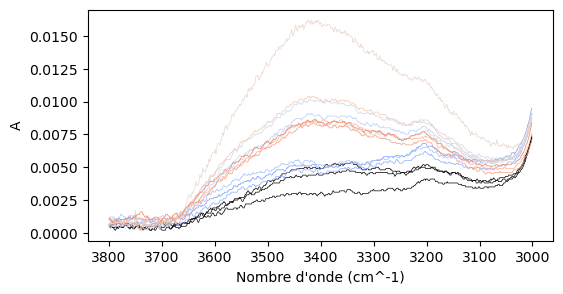

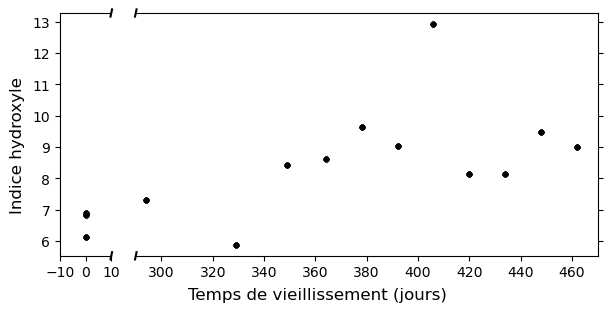

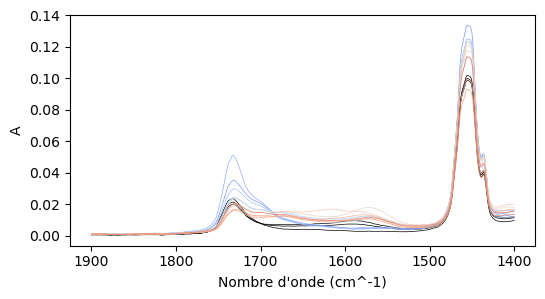

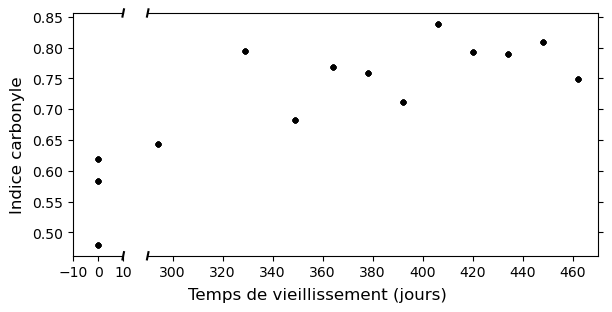

In [22]:
# Annexe 12
tape = 'RAA16'
compound = 'PP'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_test(data_working, 3999, 401)

plot_spectrum_small(data_working, 3800, 3000)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 3700, 3100, 1425, 1395), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice hydroxyle')


plot_spectrum_small(data_working, 1900, 1400)

data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1520, 1500, 1410), axis=1)
data_plot = pd.DataFrame(data_working, columns=['I', 'age'])
plot_figure(data_plot, 'Indice carbonyle')

## Plots Figures

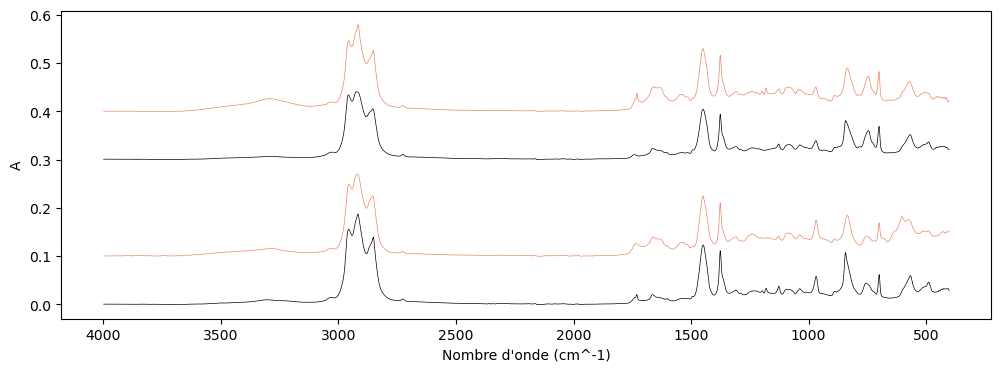

In [24]:
# Figure 13
compound = 'Caoutchouc'
data_working = data[data['compound'] == compound]
rows_to_keep = [1, 13, 56, 69]
data_filtered = data_working.loc[rows_to_keep]

def plot_spectrum_vshift(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(12, 4))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    A = data_plot_spectra.values[:, 1:-4][0][(4000-w_start):(400-w_end)]
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][1][(4000-w_start):(400-w_end)]
    A += 0.1
    color = cmap[3]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
  
    A = data_plot_spectra.values[:, 1:-4][2][(4000-w_start):(400-w_end)]
    A += 0.3
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][3][(4000-w_start):(400-w_end)]
    A += 0.4
    color = cmap[3]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()

plot_spectrum_vshift(data_filtered, 3999, 401)

/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2474151209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 3700, 3100, 1490, 1400), axis=1)
/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2474151209.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax1.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.1), alpha=0.1, s=10)
/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2474151209.py:32: MatplotlibDeprecationWarning: The get_cmap funct

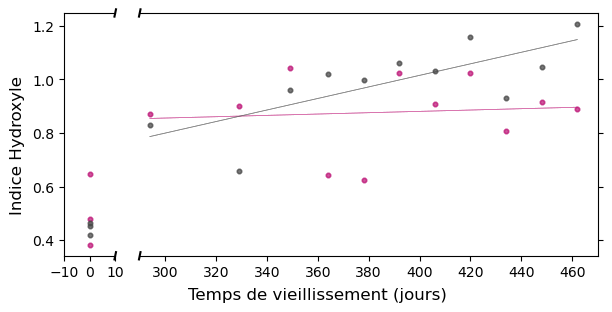

In [25]:
# Figure 16 a
compound = 'Caoutchouc'
data_working = data[data['compound'] == compound]
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 3700, 3100, 1490, 1400), axis=1)
data_working_1 = data_working[data_working['tape'] == 'RAA12']
data_working_2 = data_working[data_working['tape'] == 'RAA14']
data_plot1 = pd.DataFrame(data_working_1, columns=['I', 'age'])
data_plot2 = pd.DataFrame(data_working_2, columns=['I', 'age'])


y_label='Indice Hydroxyle'
#std_value = 0.008531

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

x_values1 = data_plot1['age']
y_values1 = data_plot1['I']

groups = data_plot1.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.1), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.1), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)

    # Filter data for regression
    mask1 = x_values1 > 100
    x_regression1 = x_values1[mask1]
    y_regression1 = y_values1[mask1]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression1, y_regression1)
    ax2.plot(x_regression1, intercept + slope * x_regression1, color=cm.get_cmap('PiYG')(0.1), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
x_values2 = data_plot2['age']
y_values2 = data_plot2['I']

groups = data_plot2.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values2, y_values2, color=cm.get_cmap('RdGy')(0.9), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values2, y_values2, color=cm.get_cmap('RdGy')(0.9), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)
    
    # Filter data for regression
    mask2 = x_values2 > 100
    x_regression2 = x_values2[mask2]
    y_regression2 = y_values2[mask2]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression2, y_regression2)
    ax2.plot(x_regression2, intercept + slope * x_regression2, color=cm.get_cmap('RdGy')(0.9), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
# Hide the spines and ticks between the plots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

# Set labels and title for the subplot
fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

#plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2316281036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1504, 1490, 1400), axis=1)
/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2316281036.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax1.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.1), alpha=0.1, s=10)
/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2316281036.py:32: MatplotlibDeprecationWarning: The get_cmap funct

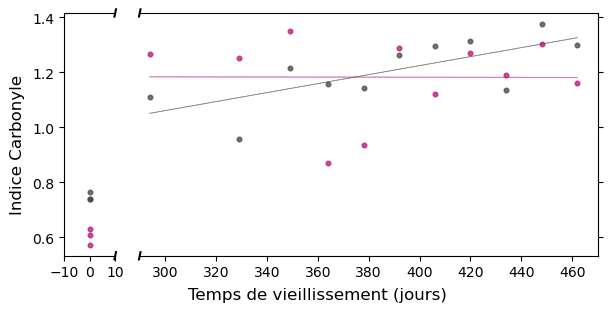

In [26]:
# Figure 16 b
compound = 'Caoutchouc'
data_working = data[data['compound'] == compound]
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1504, 1490, 1400), axis=1)
data_working_1 = data_working[data_working['tape'] == 'RAA12']
data_working_2 = data_working[data_working['tape'] == 'RAA14']
data_plot1 = pd.DataFrame(data_working_1, columns=['I', 'age'])
data_plot2 = pd.DataFrame(data_working_2, columns=['I', 'age'])


y_label='Indice Carbonyle'
#std_value = 0.008531

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

x_values1 = data_plot1['age']
y_values1 = data_plot1['I']

groups = data_plot1.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.1), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.1), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)

    # Filter data for regression
    mask1 = x_values1 > 100
    x_regression1 = x_values1[mask1]
    y_regression1 = y_values1[mask1]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression1, y_regression1)
    ax2.plot(x_regression1, intercept + slope * x_regression1, color=cm.get_cmap('PiYG')(0.1), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
x_values2 = data_plot2['age']
y_values2 = data_plot2['I']

groups = data_plot2.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values2, y_values2, color=cm.get_cmap('RdGy')(0.9), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values2, y_values2, color=cm.get_cmap('RdGy')(0.9), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)
    
    # Filter data for regression
    mask2 = x_values2 > 100
    x_regression2 = x_values2[mask2]
    y_regression2 = y_values2[mask2]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression2, y_regression2)
    ax2.plot(x_regression2, intercept + slope * x_regression2, color=cm.get_cmap('RdGy')(0.9), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
# Hide the spines and ticks between the plots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

# Set labels and title for the subplot
fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

#plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

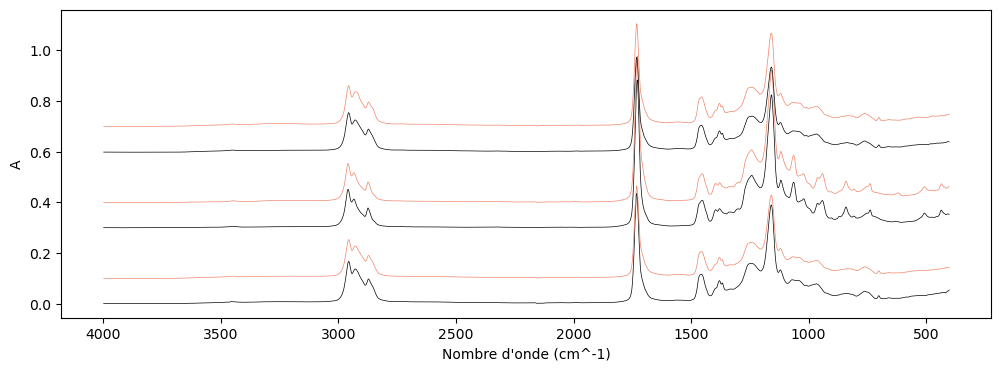

In [27]:
# Figure 17
compound = 'Acrylique'
data_working = data[data['compound'] == compound]
rows_to_keep = [42, 55, 84, 97, 112, 125]
data_filtered = data_working.loc[rows_to_keep]

def plot_spectrum_modified(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(12, 4))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    A = data_plot_spectra.values[:, 1:-4][0][(4000-w_start):(400-w_end)]
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][1][(4000-w_start):(400-w_end)]
    A += 0.1
    color = cmap[5]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
  
    A = data_plot_spectra.values[:, 1:-4][2][(4000-w_start):(400-w_end)]
    A += 0.3
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][3][(4000-w_start):(400-w_end)]
    A += 0.4
    color = cmap[5]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][4][(4000-w_start):(400-w_end)]
    A += 0.6
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][5][(4000-w_start):(400-w_end)]
    A += 0.7
    color = cmap[5]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()

plot_spectrum_modified(data_filtered, 3999, 401)

/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/91004360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1320, 1160, 1500, 1420), axis=1)
/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/91004360.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax1.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.9), alpha=0.1, s=10)
/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/91004360.py:34: MatplotlibDeprecationWarning: The get_cmap function wa

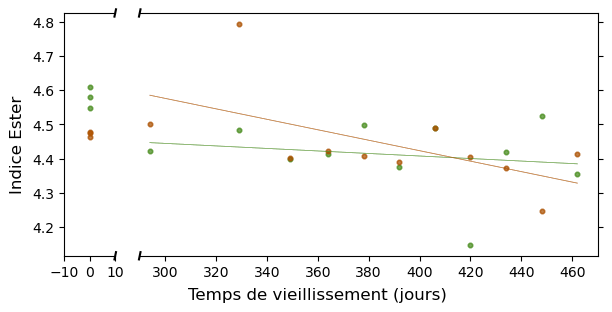

In [28]:
# Figure 19 a
compound = 'Acrylique'
data_working = data[data['compound'] == compound]
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1320, 1160, 1500, 1420), axis=1)
data_working_1 = data_working[data_working['tape'] == 'RAA13']
data_working_2 = data_working[data_working['tape'] == 'RAA15']
data_working_3 = data_working[data_working['tape'] == 'RAA16']
data_plot1 = pd.DataFrame(data_working_1, columns=['I', 'age'])
data_plot2 = pd.DataFrame(data_working_2, columns=['I', 'age'])
data_plot3 = pd.DataFrame(data_working_3, columns=['I', 'age'])


y_label='Indice Ester'
#std_value = 0.008531

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

x_values1 = data_plot1['age']
y_values1 = data_plot1['I']

groups = data_plot1.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.9), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.9), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)

    # Filter data for regression
    mask1 = x_values1 > 100
    x_regression1 = x_values1[mask1]
    y_regression1 = y_values1[mask1]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression1, y_regression1)
    ax2.plot(x_regression1, intercept + slope * x_regression1, color=cm.get_cmap('PiYG')(0.9), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
x_values2 = data_plot2['age']
y_values2 = data_plot2['I']

groups = data_plot2.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    #ax1.scatter(x_values2, y_values2, color=cm.get_cmap('BrBG')(0.9), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    #ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    #ax2.scatter(x_values2, y_values2, color=cm.get_cmap('BrBG')(0.9), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    #ax2.set_xlim(290, 470)
    
    # Filter data for regression
    mask2 = x_values2 > 100
    x_regression2 = x_values2[mask2]
    y_regression2 = y_values2[mask2]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression2, y_regression2)
    #ax2.plot(x_regression2, intercept + slope * x_regression2, color=cm.get_cmap('BrBG')(0.9), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

x_values3 = data_plot3['age']
y_values3 = data_plot3['I']

groups = data_plot3.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values3, y_values3, color=cm.get_cmap('PuOr')(0.1), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values3, y_values3, color=cm.get_cmap('PuOr')(0.1), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)
    
    # Filter data for regression
    mask3 = x_values3 > 100
    x_regression3 = x_values3[mask3]
    y_regression3 = y_values3[mask3]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression3, y_regression3)
    ax2.plot(x_regression3, intercept + slope * x_regression3, color=cm.get_cmap('PuOr')(0.1), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
# Hide the spines and ticks between the plots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

# Set labels and title for the subplot
fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

#plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2592474565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1320, 1160, 1500, 1420), axis=1)
/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2592474565.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax1.scatter(x_values2, y_values2, color=cm.get_cmap('BrBG')(0.9), alpha=0.1, s=10)
/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/2592474565.py:63: MatplotlibDeprecationWarning: The get_cmap funct

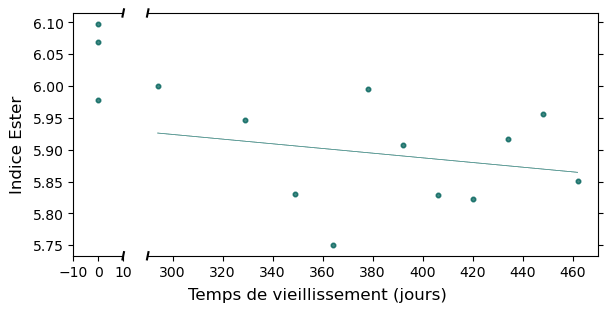

In [29]:
# Figure 19 b
compound = 'Acrylique'
data_working = data[data['compound'] == compound]
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1320, 1160, 1500, 1420), axis=1)
data_working_1 = data_working[data_working['tape'] == 'RAA13']
data_working_2 = data_working[data_working['tape'] == 'RAA15']
data_working_3 = data_working[data_working['tape'] == 'RAA16']
data_plot1 = pd.DataFrame(data_working_1, columns=['I', 'age'])
data_plot2 = pd.DataFrame(data_working_2, columns=['I', 'age'])
data_plot3 = pd.DataFrame(data_working_3, columns=['I', 'age'])


y_label='Indice Ester'
#std_value = 0.008531

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

x_values1 = data_plot1['age']
y_values1 = data_plot1['I']

groups = data_plot1.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    #ax1.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.9), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    #ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    #ax2.scatter(x_values1, y_values1, color=cm.get_cmap('PiYG')(0.9), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    #ax2.set_xlim(290, 470)

    # Filter data for regression
    mask1 = x_values1 > 100
    x_regression1 = x_values1[mask1]
    y_regression1 = y_values1[mask1]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression1, y_regression1)
    #ax2.plot(x_regression1, intercept + slope * x_regression1, color=cm.get_cmap('PiYG')(0.9), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
x_values2 = data_plot2['age']
y_values2 = data_plot2['I']

groups = data_plot2.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values2, y_values2, color=cm.get_cmap('BrBG')(0.9), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values2, y_values2, color=cm.get_cmap('BrBG')(0.9), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)
    
    # Filter data for regression
    mask2 = x_values2 > 100
    x_regression2 = x_values2[mask2]
    y_regression2 = y_values2[mask2]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression2, y_regression2)
    ax2.plot(x_regression2, intercept + slope * x_regression2, color=cm.get_cmap('BrBG')(0.9), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

x_values3 = data_plot3['age']
y_values3 = data_plot3['I']

groups = data_plot3.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    #ax1.scatter(x_values3, y_values3, color=cm.get_cmap('PuOr')(0.1), alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    #ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    #ax2.scatter(x_values3, y_values3, color=cm.get_cmap('PuOr')(0.1), alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    #ax2.set_xlim(290, 470)
    
    # Filter data for regression
    mask3 = x_values3 > 100
    x_regression3 = x_values3[mask3]
    y_regression3 = y_values3[mask3]

    # Linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(x_regression3, y_regression3)
    #ax2.plot(x_regression3, intercept + slope * x_regression3, color=cm.get_cmap('PuOr')(0.1), linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
# Hide the spines and ticks between the plots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

# Set labels and title for the subplot
fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

#plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

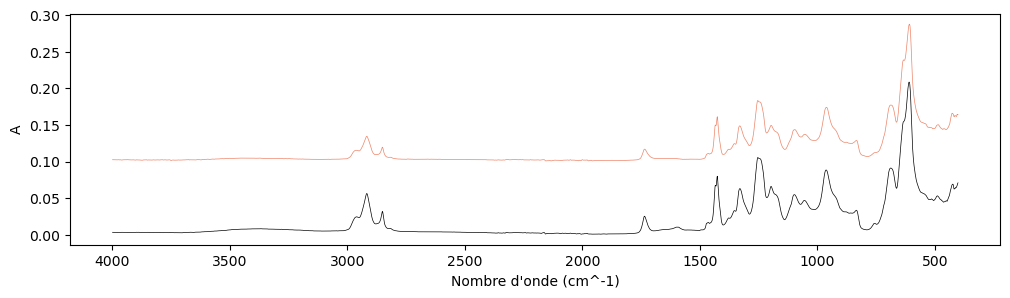

In [30]:
# Figure 20
compound = 'PVC'
data_working = data[data['compound'] == compound]
rows_to_keep = [16, 27]
data_filtered = data_working.loc[rows_to_keep]

def plot_spectrum_vshift(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(12, 3))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    A = data_plot_spectra.values[:, 1:-4][0][(4000-w_start):(400-w_end)]
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][1][(4000-w_start):(400-w_end)]
    A += 0.1
    color = cmap[1]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)

    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()

plot_spectrum_vshift(data_filtered, 3999, 401)

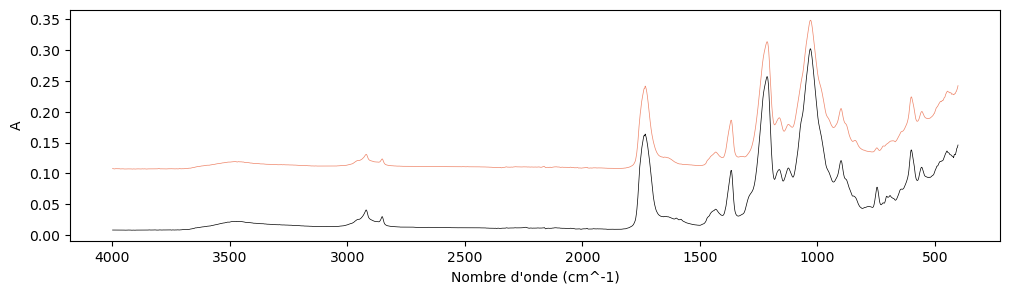

In [31]:
# Figure 23
compound = 'AC'
data_working = data[data['compound'] == compound]
rows_to_keep = [30, 41]
data_filtered = data_working.loc[rows_to_keep]

def plot_spectrum_vshift(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(12, 3))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    A = data_plot_spectra.values[:, 1:-4][0][(4000-w_start):(400-w_end)]
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][1][(4000-w_start):(400-w_end)]
    A += 0.1
    color = cmap[1]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)

    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()

plot_spectrum_vshift(data_filtered, 3999, 401)

/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/66475121.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1340, 1182, 1100, 925), axis=1)


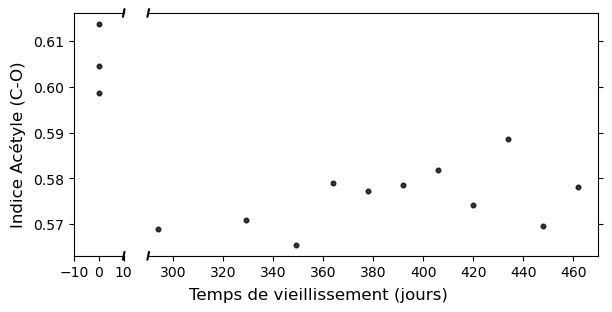

In [32]:
# Figure 25 a
compound = 'AC'
data_working = data[data['compound'] == compound]
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1340, 1182, 1100, 925), axis=1)
data_working_1 = data_working[data_working['tape'] == 'RAA13']
data_plot1 = pd.DataFrame(data_working_1, columns=['I', 'age'])


y_label='Indice Acétyle (C-O)'
#std_value = 0.008531

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

x_values1 = data_plot1['age']
y_values1 = data_plot1['I']


groups = data_plot1.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values1, y_values1, color='black', alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values1, y_values1, color='black', alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)

    # Filter data for regression
    mask1 = x_values1 > 100
    x_regression1 = x_values1[mask1]
    y_regression1 = y_values1[mask1]

    # Linear regression line
    #slope, intercept, r_value, p_value, std_err = linregress(x_regression1, y_regression1)
    #ax2.plot(x_regression1, intercept + slope * x_regression1, color='black', linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
# Hide the spines and ticks between the plots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

# Set labels and title for the subplot
fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

#plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/818046772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 765, 730, 1100, 925), axis=1)


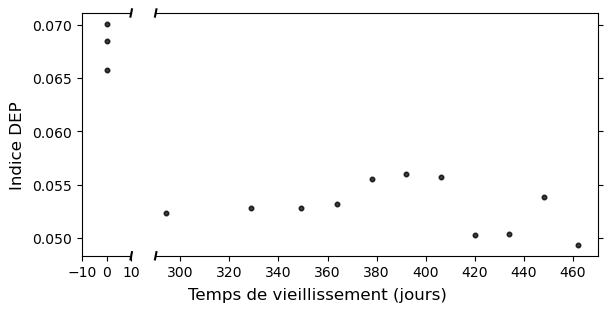

In [33]:
# Figure 25 b
compound = 'AC'
data_working = data[data['compound'] == compound]
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 765, 730, 1100, 925), axis=1)
data_working_1 = data_working[data_working['tape'] == 'RAA13']
data_plot1 = pd.DataFrame(data_working_1, columns=['I', 'age'])


y_label='Indice DEP'
#std_value = 0.008531

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

x_values1 = data_plot1['age']
y_values1 = data_plot1['I']


groups = data_plot1.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values1, y_values1, color='black', alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values1, y_values1, color='black', alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)

    # Filter data for regression
    mask1 = x_values1 > 100
    x_regression1 = x_values1[mask1]
    y_regression1 = y_values1[mask1]

    # Linear regression line
    #slope, intercept, r_value, p_value, std_err = linregress(x_regression1, y_regression1)
    #ax2.plot(x_regression1, intercept + slope * x_regression1, color='black', linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
# Hide the spines and ticks between the plots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

# Set labels and title for the subplot
fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

#plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

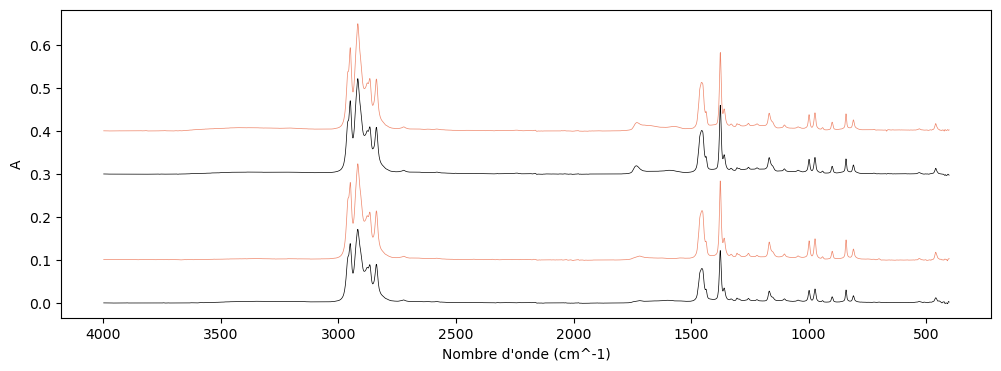

In [34]:
# Figure 26
compound = 'PP'
data_working = data[data['compound'] == compound]
rows_to_keep = [72, 83, 128, 139]
data_filtered = data_working.loc[rows_to_keep]

def plot_spectrum_vshift(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(12, 4))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    A = data_plot_spectra.values[:, 1:-4][0][(4000-w_start):(400-w_end)]
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][1][(4000-w_start):(400-w_end)]
    A += 0.1
    color = cmap[3]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
  
    A = data_plot_spectra.values[:, 1:-4][2][(4000-w_start):(400-w_end)]
    A += 0.3
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][3][(4000-w_start):(400-w_end)]
    A += 0.4
    color = cmap[3]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()

plot_spectrum_vshift(data_filtered, 3999, 401)

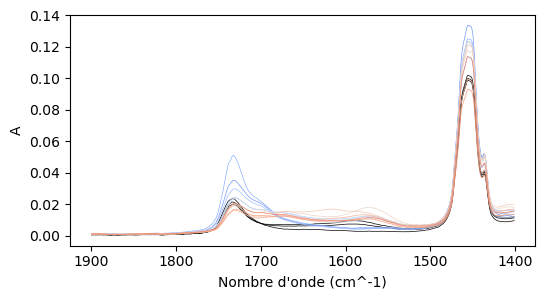

In [35]:
# Figure 28 a
def plot_spectrum_modified(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(6, 3))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    for row in range(len(data_plot_spectra.values[:, 1:-4])):
        A = data_plot_spectra.values[:, 1:-4][row][(4000-w_start):(400-w_end)]
        #color = 'red'
        color = cmap[row]

        if data_plot_spectra.values[row, data_plot_spectra.columns.get_loc('age')] == 0:
            color = 'black'
        plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)

    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()
    
tape = 'RAA16'
compound = 'PP'
data_working = data[data['tape'] == tape]
data_working = data_working[data_working['compound'] == compound]

plot_spectrum_modified(data_working, 1900, 1400)

/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/1895898915.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1520, 1500, 1410), axis=1)


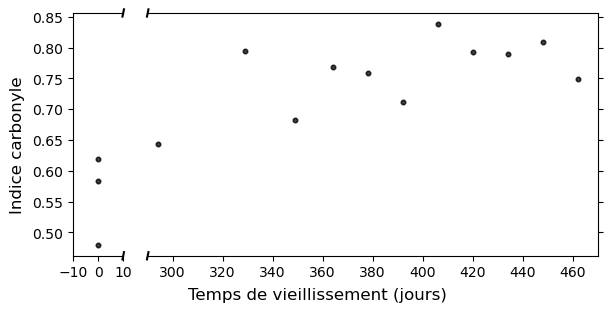

In [36]:
# Figure 28 b
compound = 'PP'
data_working = data[data['compound'] == compound]
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 1820, 1520, 1500, 1410), axis=1)
data_working_1 = data_working[data_working['tape'] == 'RAA16']
data_plot1 = pd.DataFrame(data_working_1, columns=['I', 'age'])


y_label='Indice carbonyle'
#std_value = 0.008531

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

x_values1 = data_plot1['age']
y_values1 = data_plot1['I']


groups = data_plot1.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values1, y_values1, color='black', alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values1, y_values1, color='black', alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)

    # Filter data for regression
    mask1 = x_values1 > 100
    x_regression1 = x_values1[mask1]
    y_regression1 = y_values1[mask1]

    # Linear regression line
    #slope, intercept, r_value, p_value, std_err = linregress(x_regression1, y_regression1)
    #ax2.plot(x_regression1, intercept + slope * x_regression1, color='black', linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
# Hide the spines and ticks between the plots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

# Set labels and title for the subplot
fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

#plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

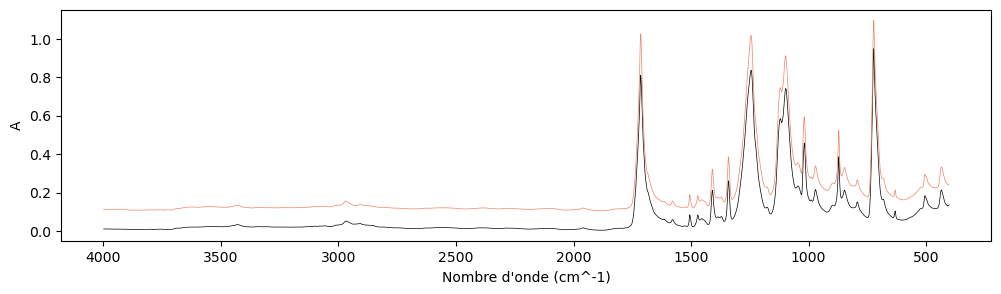

In [37]:
# Figure 29
compound = 'PET'
data_working = data[data['compound'] == compound]
rows_to_keep = [100, 111]
data_filtered = data_working.loc[rows_to_keep]

def plot_spectrum_vshift(data_plot_spectra, w_start, w_end):
    Wavelength = data_plot_spectra.columns[1+(4000-w_start):-4+(400-w_end)]
    plt.figure(figsize=(12, 3))
    cmap = plt.cm.coolwarm(np.linspace(0, 0.8, len(data_plot_spectra.values[:, 1:-4])))
    
    A = data_plot_spectra.values[:, 1:-4][0][(4000-w_start):(400-w_end)]
    color = 'black'
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)
    
    A = data_plot_spectra.values[:, 1:-4][1][(4000-w_start):(400-w_end)]
    A += 0.1
    color = cmap[1]
    plt.plot(Wavelength, A, color=color, linestyle='-', linewidth=0.5, alpha=1)

    plt.xlabel('Nombre d\'onde (cm^-1)')
    plt.ylabel('A')
    #plt.title(' d=0')
    plt.gca().invert_xaxis()
    plt.show()

plot_spectrum_vshift(data_filtered, 3999, 401)

/var/folders/5r/m2ph__1n7v32bjbs9kddlf9r0000gn/T/ipykernel_53745/818046772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 765, 730, 1100, 925), axis=1)


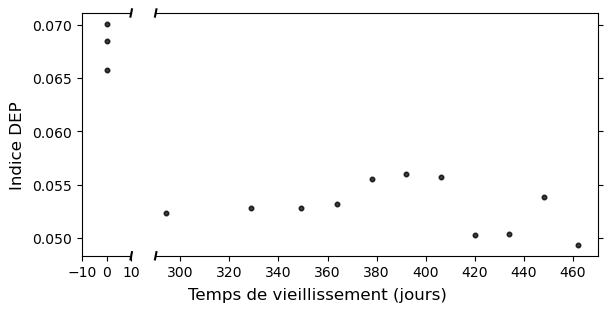

In [38]:
# Figure 25 b
compound = 'AC'
data_working = data[data['compound'] == compound]
data_working['I'] = data_working.apply(lambda row: indice_area(data, row.name, 765, 730, 1100, 925), axis=1)
data_working_1 = data_working[data_working['tape'] == 'RAA13']
data_plot1 = pd.DataFrame(data_working_1, columns=['I', 'age'])


y_label='Indice DEP'
#std_value = 0.008531

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 9]})

x_values1 = data_plot1['age']
y_values1 = data_plot1['I']


groups = data_plot1.groupby('age')

for age_value, group_data in groups:
    mean_value = np.mean(group_data['I'])

    # Plot the data points and error bars
    # Left plot (before the gap)
    ax1.scatter(x_values1, y_values1, color='black', alpha=0.1, s=10)
    #ax1.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax1.set_xlim(-10, 10)

    # Right plot (after the gap)
    ax2.scatter(x_values1, y_values1, color='black', alpha=0.1, s=10)
    #ax2.errorbar(age_value, mean_value, yerr=std_value, fmt='+', color='black', alpha=0.5)
    ax2.set_xlim(290, 470)

    # Filter data for regression
    mask1 = x_values1 > 100
    x_regression1 = x_values1[mask1]
    y_regression1 = y_values1[mask1]

    # Linear regression line
    #slope, intercept, r_value, p_value, std_err = linregress(x_regression1, y_regression1)
    #ax2.plot(x_regression1, intercept + slope * x_regression1, color='black', linestyle='-', alpha=0.1, linewidth=0.5, label='Regression Line')

    
# Hide the spines and ticks between the plots
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # Bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-(1/9)*d, +(1/9)*d), (-d, +d), **kwargs)  # Top-right diagonal
ax2.plot((-(1/9)*d, +(1/9)*d), (1-d, 1+d), **kwargs)  # Bottom-right diagonal

# Set labels and title for the subplot
fig.text(0.5, 0.0, 'Temps de vieillissement (jours)', ha='center', va='center', fontsize=12)
fig.text(0.0, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=12)

#plt.savefig('IC EDSC.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()